# 1. Import modules

In [1]:
from dataclasses import dataclass

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

plt.style.use("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/config/DIT_HAP.mplstyle")
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
AX_WIDTH, AX_HEIGHT = plt.rcParams['figure.figsize']

# 2.Configuration

In [15]:
@dataclass
class Config:

    project_dir: Path = Path("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP_generationPLUS1")
    # project_dir: Path = Path("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP_generationRAW")

    @property
    def deletion_library_essentiality(self) -> pd.DataFrame:
        return pd.read_excel("../../resources/Hayles_2013_OB_merged_categories_sysIDupdated.xlsx")[["Updated_Systematic_ID", "One or multi basic phenotypes", "Category"]]

    @property
    def gene_level_result(self) -> pd.DataFrame:
        return pd.read_csv(self.project_dir / "17_gene_level_curve_fitting/gene_level_fitting_statistics.tsv", sep="\t")

    @property
    def verification_result(self) -> pd.DataFrame:
        verification = pd.read_excel("../../resources/verfication_results_summary.xlsx")
        verification.dropna(subset=["Verified essentiality"], inplace=True)
        verification["Verification result"].replace(
            {
                "WT-like": "WT",
                "Very small colony": "very small colonies",
                "Small colony": "small colonies",
                "E, Very small colony": "E",
                "E & very small colonies": "E",
                "small colonies (unequal)": "small colonies",
                "very small colonies (unequal)": "very small colonies",
                "E, 2 & 3": "E",
                "Small colony, Very small colony": "small colonies",
            },
            inplace=True
        )
        return verification

    def __post_init__(self):
        res = pd.merge(self.gene_level_result, self.deletion_library_essentiality, left_on="Systematic ID", right_on="Updated_Systematic_ID", how="left").drop(columns=["Updated_Systematic_ID"])
        res["Category_with_essentiality"] = res.apply(lambda row: f"{row['Category']} ({row['DeletionLibrary_essentiality']})" if row["Category"] == 'small colonies' and row["DeletionLibrary_essentiality"] == "E" else row["Category"], axis=1)
        self.merged_result = res.copy()

        self.output_dir = self.project_dir / "20_essentiality_verification"
        self.output_dir.mkdir(exist_ok=True, parents=True)

data_config = Config()


# 3. Data preparation

In [16]:
selected_categories = ["spores", "germinated", "microcolonies", "very small colonies", "small colonies", "WT"]
# selected_categories_with_essentiality = ["spores", "germinated", "microcolonies", "very small colonies", "small colonies", "WT"]

In [24]:
um_dict = data_config.merged_result.query("Category in @selected_categories").groupby("Category_with_essentiality")["um"].apply(list).to_dict()
um_dict = {
    "WT": um_dict["WT"],
    "small colonies": um_dict["small colonies"],
    "very small colonies": um_dict["very small colonies"],
    "microcolonies": um_dict["microcolonies"],
    "germinated": um_dict["germinated"],
    "spores": um_dict["spores"],
}

WT2E = data_config.merged_result.query("Category == 'WT' and um > 0.35").sort_values(by="um", ascending=False)["Systematic ID"].unique().tolist()
verified_WT2E = data_config.verification_result.query("`Systematic ID` in @WT2E").copy()
verified_WT2E_genes = verified_WT2E["Systematic ID"].unique().tolist()
missing_WT2E_genes = [gene for gene in WT2E if gene not in verified_WT2E_genes]

verification_genes = {}
verification_genes["Not verified"] = missing_WT2E_genes
for category in ["WT", "small colonies", "very small colonies", "E"]:
    verification_genes[category] = verified_WT2E.query("`Verification result` == @category")["Systematic ID"].unique().tolist()

WT2E_genes_df = pd.DataFrame()
for k, v in verification_genes.items():
    sub_df = data_config.merged_result.query("`Systematic ID` in @v").copy()
    sub_df["Verification result"] = k
    WT2E_genes_df = pd.concat([WT2E_genes_df, sub_df], ignore_index=True)

print("WT2E: ", len(WT2E))
print("verified_WT2E: ", len(verified_WT2E))

um_dict2 = { k: data_config.merged_result.query("`Systematic ID` in @v")["um"].tolist() for k, v in verification_genes.items() }

WT2E:  225
verified_WT2E:  144


/tmp/ipykernel_813138/3012127638.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  verification["Verification result"].replace(


In [26]:
WT2E_genes_df.to_csv(data_config.output_dir / "WT2E_genes_verification_summary.tsv", sep="\t", index=False)

# 4. Boxplot

In [22]:
def boxplot_with_violinplot(x, y, ax, colors):
    # Create violin plot
    parts = ax.violinplot(y, 
                         positions=range(len(x)),
                         showmeans=False, showmedians=False, showextrema=False, orientation="horizontal")
    
    # Style violin plots
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.6)
    
    # Create box plot
    box_parts = ax.boxplot(y, 
                          positions=range(len(x)),
                          widths=0.2, patch_artist=True, 
                          medianprops=dict(color='black', linewidth=2),
                          orientation="horizontal")

    for i, bp in enumerate(box_parts['boxes']):
        bp.set_facecolor(colors[i])
        bp.set_alpha(0.8)

    # Set x-axis labels
    ax.set_yticks(range(len(x)))
    tick_labels = [f"{l} (n={len(y[i])})" for i, l in enumerate(x)]
    ax.set_yticklabels(tick_labels, fontweight='bold')
    ax.tick_params(axis='y', which='minor', length=0)


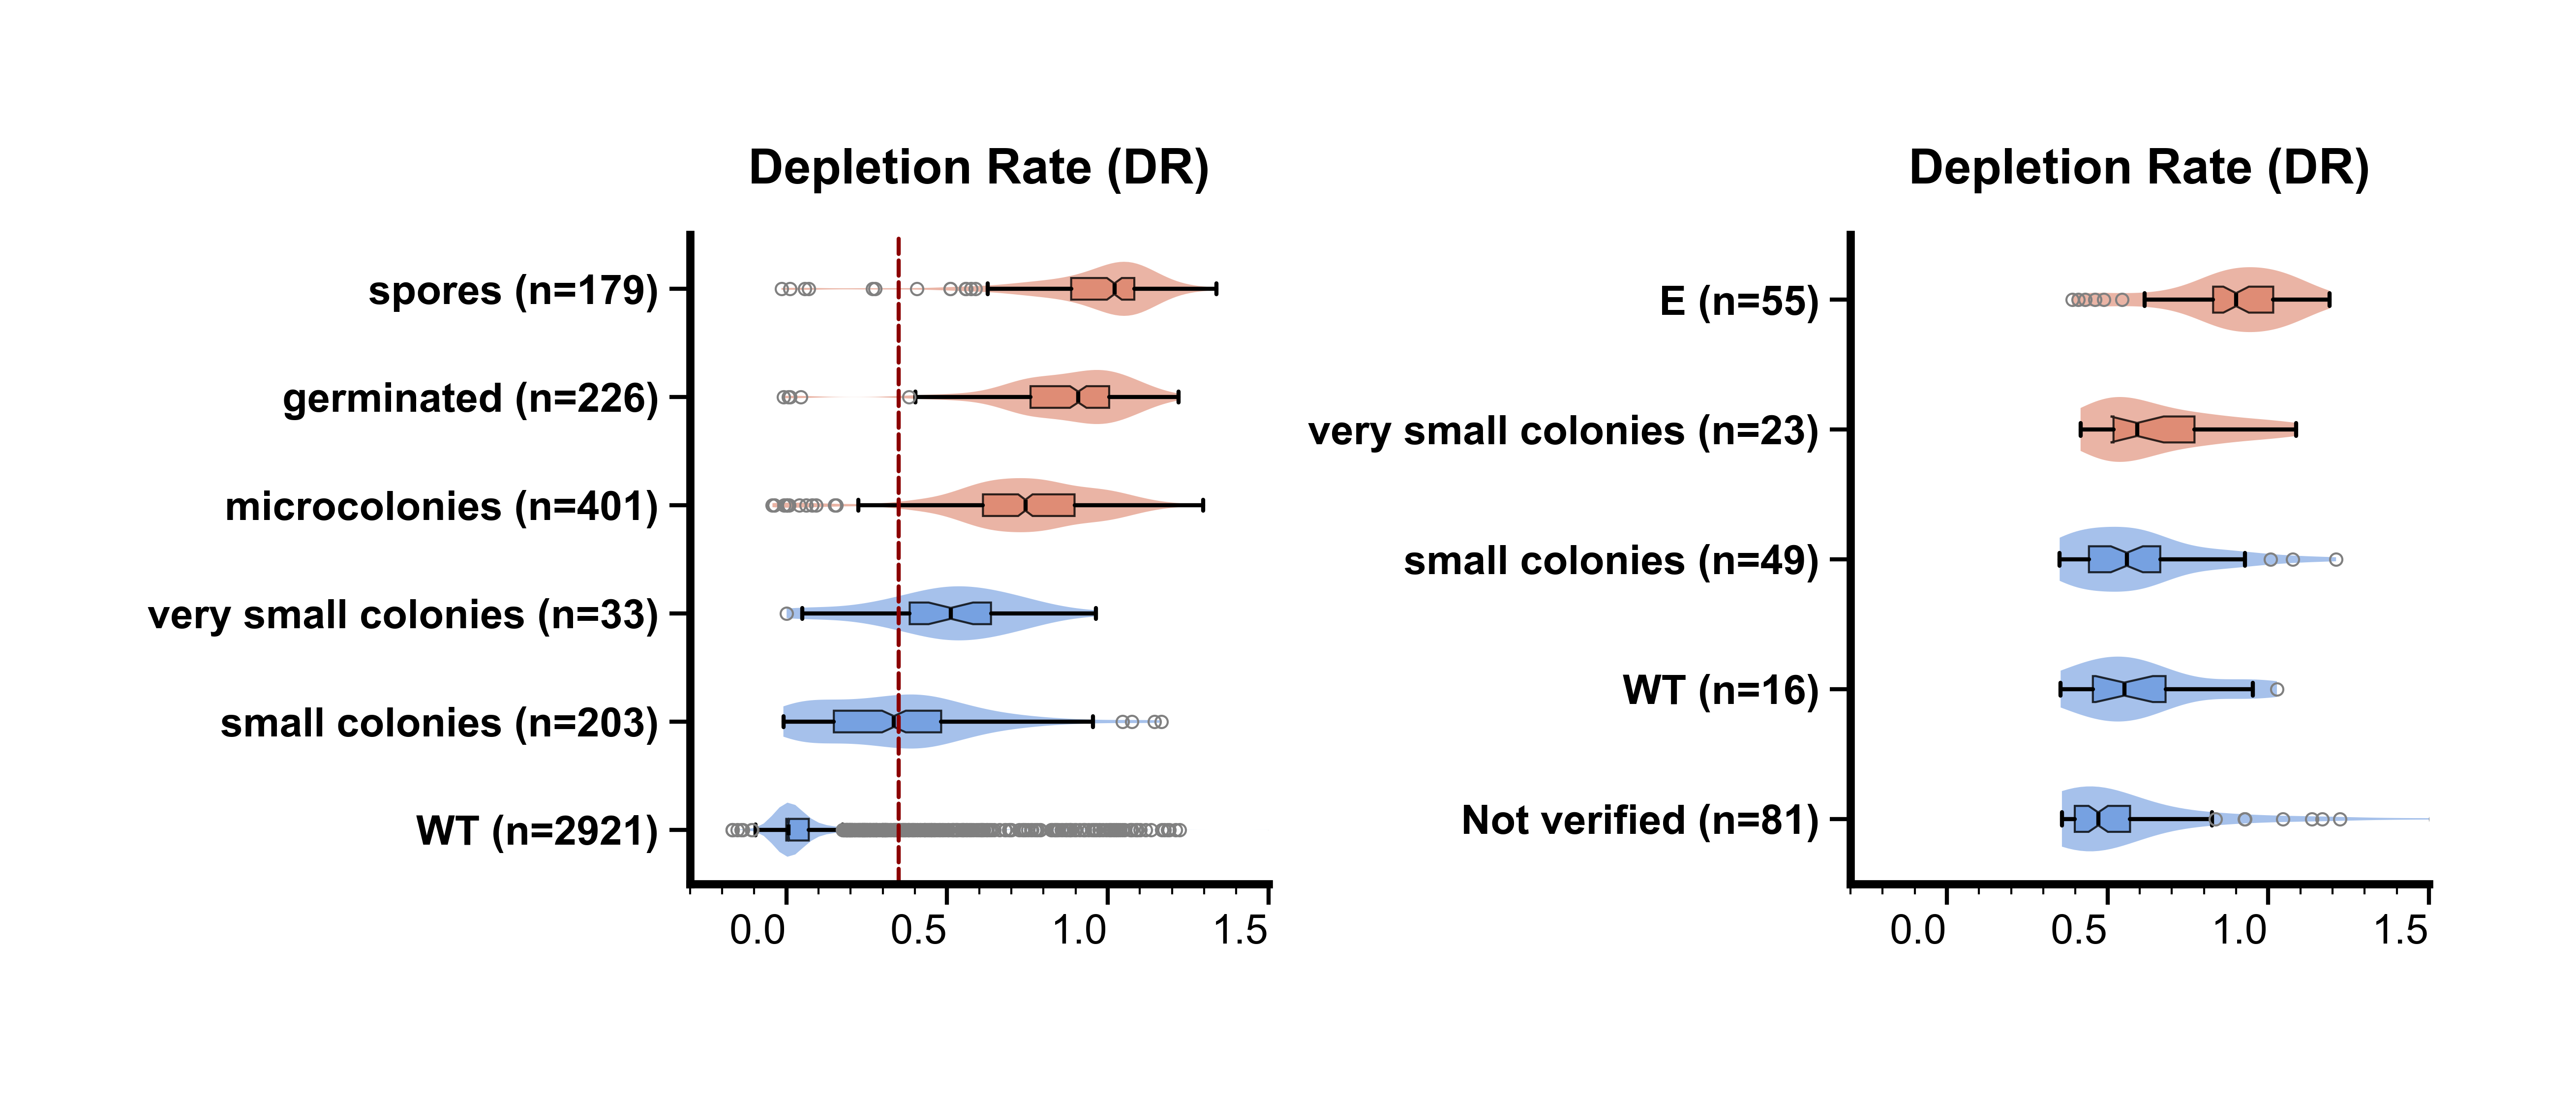

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(2*AX_WIDTH, AX_HEIGHT), sharex=True)

EV_colors = [
    COLORS[1],
    COLORS[1],
    COLORS[1],
    COLORS[0],
    COLORS[0],
    COLORS[0]
]

boxplot_with_violinplot(list(um_dict.keys()), list(um_dict.values()), axes[0], EV_colors)
axes[0].set_title("Depletion Rate (DR)")
axes[0].set_xlim(-0.3, 1.5)
axes[0].axvline(0.35, color="darkred", linestyle="--", linewidth=2)
boxplot_with_violinplot(list(um_dict2.keys()), list(um_dict2.values()), axes[1], EV_colors)
axes[1].set_title("Depletion Rate (DR)")

plt.tight_layout()
plt.show()
plt.close()

In [7]:
sum(map(len, list(um_dict2.values())))

230

# 5. Donut plot

In [8]:
verified_WT2E["Verification result"].value_counts()

Verification result
E                       55
small colonies          50
very small colonies     23
WT                      16
leucine transporter?     1
Name: count, dtype: int64

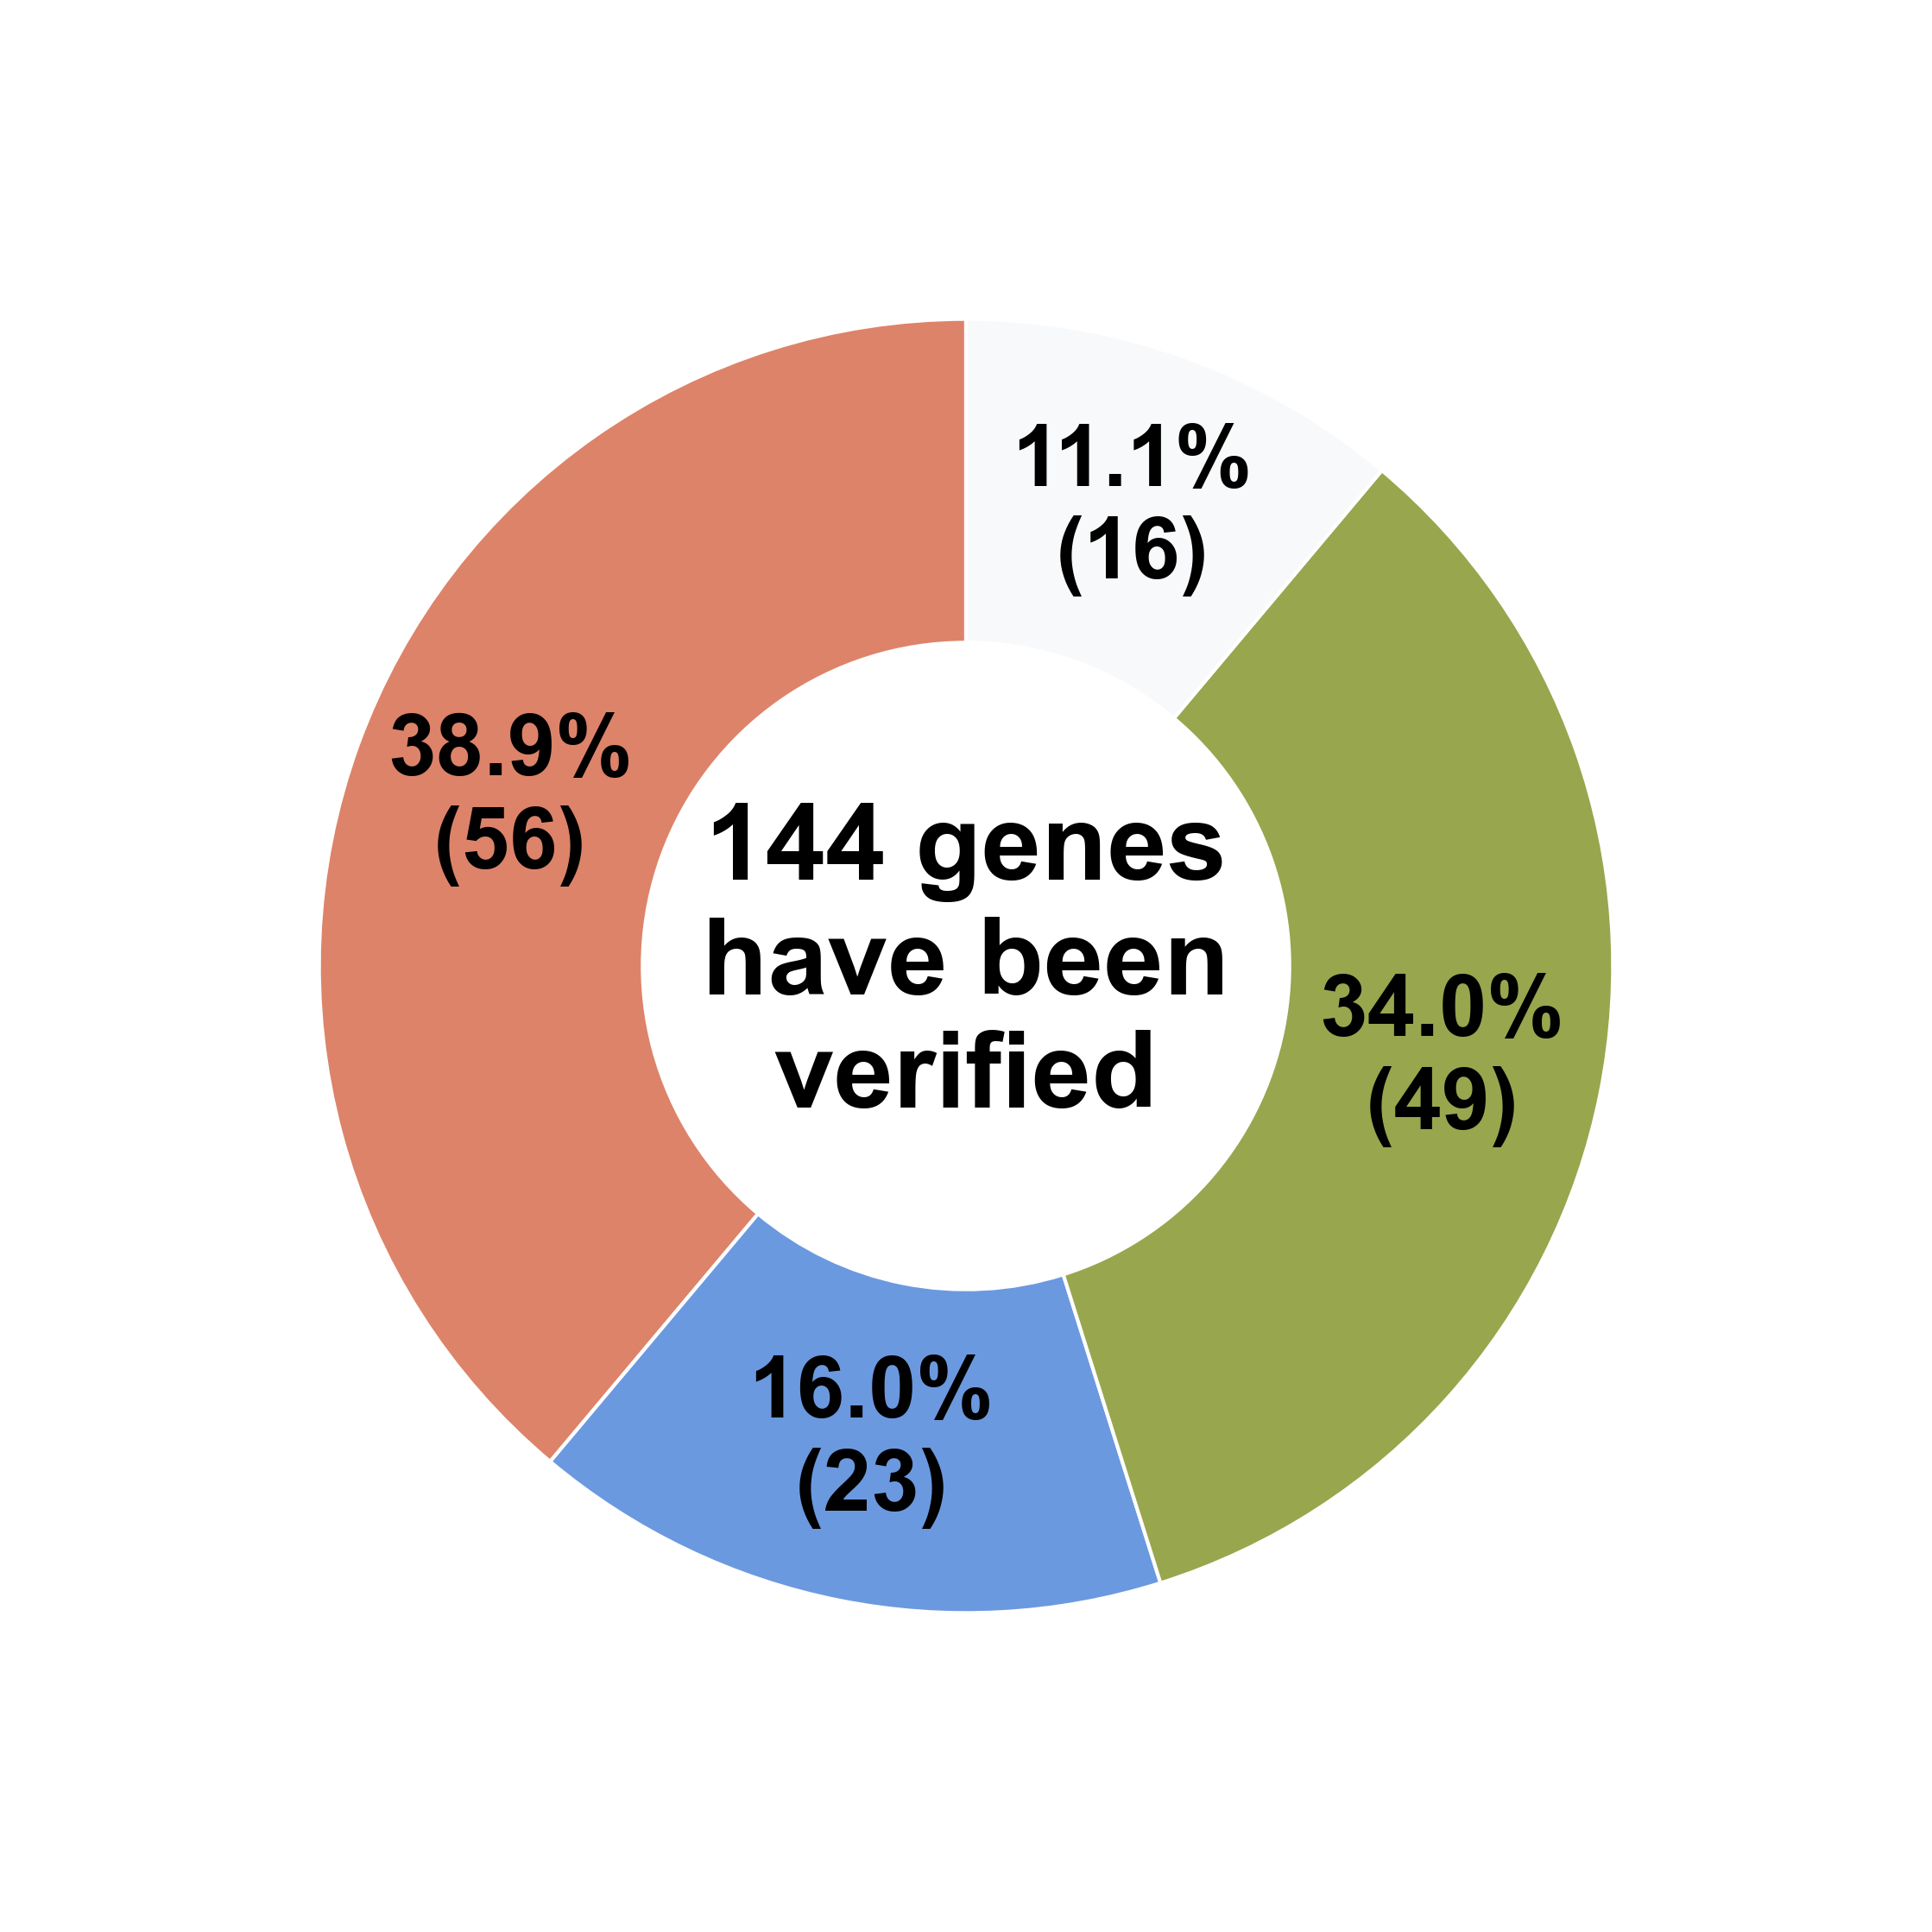

In [9]:
sizes = [56, 23, 49, 16]
labels = ['E', 'very small colonies', 'small colonies', 'WT']
fig, ax = plt.subplots(figsize=(6, 6))

# Create the donut chart
wedges, texts, autotexts = ax.pie(
    sizes, 
    # labels=labels, 
    colors=[COLORS[0], COLORS[1], COLORS[2], "#f8f9fa"],
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(sizes)):,})',
    startangle=90,
    pctdistance=0.75,
    wedgeprops=dict(width=0.5, edgecolor='white'),
    textprops={'fontsize': 24, 'weight': 'bold'},
)

# Add total count in center
ax.text(0, 0, f'144 genes\nhave been\nverified', 
        ha='center', va='center', fontsize=30, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')


plt.tight_layout()
plt.show()
plt.close()

# 6. WT2E verified as WT genes

In [11]:
print("\n".join(WT2E))

SPBC216.02
SPAC19A8.03
SPAC17C9.05c
SPBC1685.09
SPAC1805.11c
SPBC17G9.09
SPBC1652.02
SPAC1F7.04
SPAC926.09c
SPBC21C3.01c
SPCC1223.07c
SPCC1840.02c
SPAC6F6.03c
SPBC1815.01
SPBC776.03
SPBC25H2.15
SPBC2D10.10c
SPBC577.06c
SPAC24B11.13
SPAC1805.13
SPCC24B10.21
SPCC1919.09
SPAC5D6.06c
SPAC890.06
SPBC2A9.06c
SPBC685.07c
SPCC1682.16
SPBC32F12.01c
SPCC364.07
SPBC428.02c
SPAC22F3.11c
SPBC13A2.02
SPAPB1E7.09
SPAC30C2.06c
SPBC56F2.04
SPBC106.16
SPCC16C4.12
SPCC191.02c
SPAC15E1.04
SPAC227.13c
SPAC23A1.15c
SPCC777.07
SPBC646.13
SPBC23G7.12c
SPAC13C5.01c
SPAC20G8.09c
SPAC22G7.05
SPBC337.10c
SPBC409.20c
SPBC1778.05c
SPAC9.13c
SPBP22H7.08
SPBP35G2.07
SPAC57A7.04c
SPCC24B10.04
SPBC21D10.11c
SPAC25G10.09c
SPBC1289.08
SPAC13C5.05c
SPAC31A2.13c
SPBC13G1.13
SPBC56F2.12
SPBC36B7.03
SPBP8B7.22
SPCC297.03
SPCC24B10.22
SPAC1805.06c
SPAC1F3.10c
SPAC3A12.10
SPCC285.14
SPAC4A8.03c
SPCC320.04c
SPAC1783.08c
SPCC4B3.05c
SPCC1235.04c
SPBC4B4.06
SPCC1795.03
SPAC3F10.17
SPBP16F5.08c
SPBC947.13
SPBC646.09c
SPBC577.04
SP

In [13]:
WT2E_but_verified_as_WT = data_config.merged_result[data_config.merged_result["Systematic ID"].isin(verified_WT2E.query("`Verification result` == 'WT'")["Systematic ID"])].copy()
print("\n".join(WT2E_but_verified_as_WT["Name"].tolist()))

dsc2
isu1
gly1
isp6
nup155
phi1
zrt1
pus7
shr3
rps1701
pma2
cgi121
rps2802
SPCC594.04c
rgf1
eft202


In [14]:
WT2E_but_verified_as_WT

,Systematic ID,Name,FYPOviability,DeletionLibrary_essentiality,time_points,Status,A,um,lam,t10,...,YES3_fitted,YES4_fitted,YES0_residual,YES1_residual,YES2_residual,YES3_residual,YES4_residual,One or multi basic phenotypes,Category,Category_with_essentiality
253,SPAC1486.02c,dsc2,viable,V,"0.0,3.352,6.588,10.104,13.48",Success,5.219,0.440,-0.000,0.725,...,3.989,4.610,-0.344,0.617,-0.358,-0.044,0.089,One phenotype,WT,WT
781,SPAC227.13c,isu1,viable,V,"0.0,3.352,6.588,10.104,13.48",Success,5.684,0.952,0.692,1.056,...,5.475,5.638,-0.137,-0.059,0.211,0.032,-0.178,One phenotype,WT,WT
948,SPAC23H3.09c,gly1,viable,V,"0.0,3.352,6.588,10.104,13.48",Success,5.886,0.554,0.919,1.568,...,4.543,5.277,-0.189,-0.082,0.407,-0.602,0.306,One phenotype,WT,WT
1423,SPAC4A8.04,isp6,viable,V,"0.0,3.352,6.588,10.104,13.48",Success,4.070,0.682,-0.000,0.364,...,3.960,4.046,-0.269,0.771,-0.091,-0.419,0.077,One phenotype,WT,WT
1824,SPAC890.06,nup155,condition-dependent,V,"0.0,3.352,6.588,10.104,13.48",Success,6.128,1.027,1.004,1.369,...,5.869,6.071,-0.084,-0.126,0.369,-0.350,0.089,One phenotype,WT,WT
1919,SPAC9G1.08c,phi1,viable,V,"0.0,3.352,6.588,10.104,13.48",Success,5.422,0.680,3.949,4.436,...,3.885,4.879,0.000,-0.037,0.018,-0.021,0.011,One phenotype,WT,WT
2406,SPBC16D10.06,zrt1,viable,V,"0.0,3.352,6.588,10.104,13.48",Success,4.177,0.550,2.882,3.346,...,3.403,3.929,-0.002,0.089,-0.142,0.201,-0.110,One phenotype,WT,WT
2698,SPBC1A4.09,pus7,viable,V,"0.0,3.352,6.588,10.104,13.48",Success,4.188,0.548,5.497,5.964,...,2.470,3.573,0.000,0.006,-0.009,0.002,0.000,One phenotype,WT,WT
3264,SPBC409.20c,shr3,viable,V,"0.0,3.352,6.588,10.104,13.48",Success,5.288,0.886,4.129,4.494,...,4.422,5.088,0.000,0.074,-0.099,0.231,-0.160,One phenotype,WT,WT
3526,SPBC839.05c,rps1701,viable,V,"0.0,3.352,6.588,10.104,13.48",Success,5.502,0.354,0.953,1.901,...,3.182,4.062,-0.222,0.216,0.091,-0.469,0.286,One phenotype,WT,WT
